<a href="https://colab.research.google.com/github/agonzalezl2025/Parcial2/blob/main/Parcial2HE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**0. Preparación del entorno**

# New Section

## 0.1: Carga de datos

In [34]:
# === 1. Carga de Datos y Preprocesamiento ===

# Instalación silenciosa de librerías

# Frameworks de Deep Learning
!pip install -q tensorflow torch keras keras-tuner

# Análisis y manipulación de datos
!pip install -q pandas numpy scikit-learn

# Visualización
!pip install -q matplotlib seaborn plotly

# Optimización y evaluación
!pip install -q optuna tensorboard scikit-optimize

# Utilidades
!pip install -q tqdm joblib

# Análisis exploratorio y acceso a datos
!pip install -q ydata-profiling datasets huggingface_hub kaggle

# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from ydata_profiling import ProfileReport


## 0.2: Definición de semilla

In [35]:
# Definir la semilla

SEED = 42

# **1. Carga y unión de los datasets**

## 1.1: Descargar y cargar los datasets desde Kaggle

In [36]:
# === 1.1 Descargar y Cargar los Datasets desde Kaggle ===
!kaggle datasets download -d sazidthe1/world-gdp-data
!unzip world-gdp-data.zip

# Cargar los datasets con la ruta correcta
gdp_data = pd.read_csv("gdp_data.csv")
country_codes = pd.read_csv("country_codes.csv")



Dataset URL: https://www.kaggle.com/datasets/sazidthe1/world-gdp-data
License(s): Attribution 4.0 International (CC BY 4.0)
world-gdp-data.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  world-gdp-data.zip
replace country_codes.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


##  1.2: Inspección de los datos

In [37]:
# === 1.2 Inspección de los datos ===
print("Primeras filas de GDP Data:")
print(gdp_data.head())

print("\nPrimeras filas de Country Codes:")
print(country_codes.head())

Primeras filas de GDP Data:
  country_name country_code  year        value
0  Afghanistan          AFG  1960  537777811.1
1  Afghanistan          AFG  1961  548888895.6
2  Afghanistan          AFG  1962  546666677.8
3  Afghanistan          AFG  1963  751111191.1
4  Afghanistan          AFG  1964  800000044.4

Primeras filas de Country Codes:
  country_code                     region         income_group
0          ABW  Latin America & Caribbean          High income
1          AFG                 South Asia           Low income
2          AGO         Sub-Saharan Africa  Lower middle income
3          ALB      Europe & Central Asia  Upper middle income
4          AND      Europe & Central Asia          High income


## 1.3: Unir datasets

In [38]:
# === 1.3 Unir datasets ===
df = pd.merge(gdp_data, country_codes, on='country_code', how='inner')

df.head()


country_name country_code  year        value      region income_group
0  Afghanistan          AFG  1960  537777811.1  South Asia   Low income
1  Afghanistan          AFG  1961  548888895.6  South Asia   Low income
2  Afghanistan          AFG  1962  546666677.8  South Asia   Low income
3  Afghanistan          AFG  1963  751111191.1  South Asia   Low income
4  Afghanistan          AFG  1964  800000044.4  South Asia   Low income

# **2. Clasificación y separación de datos train/test**

##2.1: Clasificación de datos en terciles

In [39]:
import numpy as np
import pandas as pd

# === 1. Función para calcular terciles por año ===
def categorize_gdp_by_year(row, p30_dict, p70_dict):
    year = row['year']
    value = row['value']

    # Tomamos los terciles correspondientes a ese año
    p30 = p30_dict.get(year, np.nan)
    p70 = p70_dict.get(year, np.nan)

    # Clasificación en 30%-40%-30%
    if value < p30:
        return 'Low'
    elif value < p70:
        return 'Medium'
    else:
        return 'High'

# === 2. Calcular terciles (30% y 70%) para cada año ===
p30_by_year = df.groupby('year')['value'].quantile(0.30).to_dict()
p70_by_year = df.groupby('year')['value'].quantile(0.70).to_dict()

# === 3. Aplicar la categorización por año usando los terciles ===
df['historic_gdp'] = df.apply(lambda row: categorize_gdp_by_year(row, p30_by_year, p70_by_year), axis=1)

# Aplicar One-Hot Encoding
df = pd.get_dummies(df, columns=['historic_gdp'], prefix='GDP')

# Convertir True/False a 0/1
df[['GDP_Low', 'GDP_Medium', 'GDP_High']] = df[['GDP_Low', 'GDP_Medium', 'GDP_High']].astype(int)


# === 5. Verificar que las nuevas columnas fueron creadas correctamente ===
print("\nColumnas después del One-Hot Encoding:")
print(df.columns)

# Mostrar los primeros registros para validar
print("\nPrimeras filas del DataFrame después de One-Hot Encoding:")
display(df.head())



Columnas después del One-Hot Encoding:
Index(['country_name', 'country_code', 'year', 'value', 'region',
       'income_group', 'GDP_High', 'GDP_Low', 'GDP_Medium'],
      dtype='object')

Primeras filas del DataFrame después de One-Hot Encoding:


country_name country_code  year        value      region income_group  \
0  Afghanistan          AFG  1960  537777811.1  South Asia   Low income   
1  Afghanistan          AFG  1961  548888895.6  South Asia   Low income   
2  Afghanistan          AFG  1962  546666677.8  South Asia   Low income   
3  Afghanistan          AFG  1963  751111191.1  South Asia   Low income   
4  Afghanistan          AFG  1964  800000044.4  South Asia   Low income   

   GDP_High  GDP_Low  GDP_Medium  
0         0        0           1  
1         0        0           1  
2         0        0           1  
3         0        0           1  
4         0        0           1

## 2.2 Separaración entre 80% train y 20% test

In [40]:

# === 4. Ordenar y dividir los datos en Train-Test ===
df = df.sort_values(by='year')
year_cutoff = int(round(df['year'].quantile(0.80)))

print(f"\nAño de corte para Train-Test: {year_cutoff}")

df_train = df[df['year'] <= year_cutoff].copy()
df_test = df[df['year'] > year_cutoff].copy()

# Verificar si 'historic_gdp' está en los datasets después de dividir
print("\nColumnas en df_train:")
print(df_train.columns)

print("\nColumnas en df_test:")
print(df_test.columns)

# Mostrar los primeros datos de entrenamiento y prueba
print("\nPrimeros datos de entrenamiento:")
display(df_train.head())

print("\nPrimeros datos de prueba:")
display(df_test.head())


Año de corte para Train-Test: 2012

Columnas en df_train:
Index(['country_name', 'country_code', 'year', 'value', 'region',
       'income_group', 'GDP_High', 'GDP_Low', 'GDP_Medium'],
      dtype='object')

Columnas en df_test:
Index(['country_name', 'country_code', 'year', 'value', 'region',
       'income_group', 'GDP_High', 'GDP_Low', 'GDP_Medium'],
      dtype='object')

Primeros datos de entrenamiento:


country_name country_code  year         value                     region  \
0     Afghanistan          AFG  1960  5.377778e+08                 South Asia   
2083     Colombia          COL  1960  4.031153e+09  Latin America & Caribbean   
8399    Singapore          SGP  1960  7.047517e+08        East Asia & Pacific   
909        Belize          BLZ  1960  2.807248e+07  Latin America & Caribbean   
4142        Haiti          HTI  1960  2.731872e+08  Latin America & Caribbean   

             income_group  GDP_High  GDP_Low  GDP_Medium  
0              Low income         0        0           1  
2083  Upper middle income         1        0           0  
8399          High income         0        0           1  
909   Upper middle income         0        1           0  
4142  Lower middle income         0        1           0


Primeros datos de prueba:


country_name country_code  year         value  \
2136             Colombia          COL  2013  3.820000e+11   
8699          South Sudan          SSD  2013  1.842647e+10   
8881  St. Kitts and Nevis          KNA  2013  8.748963e+08   
1406    Brunei Darussalam          BRN  2013  1.809433e+10   
2242     Congo, Dem. Rep.          COD  2013  3.267975e+10   

                         region         income_group  GDP_High  GDP_Low  \
2136  Latin America & Caribbean  Upper middle income         1        0   
8699         Sub-Saharan Africa           Low income         0        0   
8881  Latin America & Caribbean          High income         0        1   
1406        East Asia & Pacific          High income         0        0   
2242         Sub-Saharan Africa           Low income         0        0   

      GDP_Medium  
2136           0  
8699           1  
8881           0  
1406           1  
2242           1

# **Análisis de datos**

## Diccionario

In [41]:
dict_by_country = (
    df
    .groupby('country_code')
    .apply(lambda x: x.to_dict(orient='records'))
    .to_dict()
)

# Ejemplo: mostrar el contenido para 'AFG'
dict_by_country['BEN']

<ipython-input-41-81fe1ed3b6b5>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.to_dict(orient='records'))


[{'country_name': 'Benin',
  'country_code': 'BEN',
  'year': 1960,
  'value': 226195578.1,
  'region': 'Sub-Saharan Africa',
  'income_group': 'Lower middle income',
  'GDP_High': 0,
  'GDP_Low': 1,
  'GDP_Medium': 0},
 {'country_name': 'Benin',
  'country_code': 'BEN',
  'year': 1961,
  'value': 235668220.9,
  'region': 'Sub-Saharan Africa',
  'income_group': 'Lower middle income',
  'GDP_High': 0,
  'GDP_Low': 1,
  'GDP_Medium': 0},
 {'country_name': 'Benin',
  'country_code': 'BEN',
  'year': 1962,
  'value': 236434954.3,
  'region': 'Sub-Saharan Africa',
  'income_group': 'Lower middle income',
  'GDP_High': 0,
  'GDP_Low': 1,
  'GDP_Medium': 0},
 {'country_name': 'Benin',
  'country_code': 'BEN',
  'year': 1963,
  'value': 253927697.6,
  'region': 'Sub-Saharan Africa',
  'income_group': 'Lower middle income',
  'GDP_High': 0,
  'GDP_Low': 1,
  'GDP_Medium': 0},
 {'country_name': 'Benin',
  'country_code': 'BEN',
  'year': 1964,
  'value': 269819005.8,
  'region': 'Sub-Saharan Afr

## Análisis de datos: TRAIN

In [42]:
#Confirmamos los datos TRAIN:
df_train.head()

country_name country_code  year         value                     region  \
0     Afghanistan          AFG  1960  5.377778e+08                 South Asia   
2083     Colombia          COL  1960  4.031153e+09  Latin America & Caribbean   
8399    Singapore          SGP  1960  7.047517e+08        East Asia & Pacific   
909        Belize          BLZ  1960  2.807248e+07  Latin America & Caribbean   
4142        Haiti          HTI  1960  2.731872e+08  Latin America & Caribbean   

             income_group  GDP_High  GDP_Low  GDP_Medium  
0              Low income         0        0           1  
2083  Upper middle income         1        0           0  
8399          High income         0        0           1  
909   Upper middle income         0        1           0  
4142  Lower middle income         0        1           0

In [43]:
#Análisis descriptivo de los datos de entrenamiento sin nigun cambio previo:
from ydata_profiling import ProfileReport
reporte_train = ProfileReport(df_train, title="Profiling Report Train dataset")
reporte_train.to_file("reporte_train.html")
reporte_train

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Análisis de datos: TEST

In [44]:
#Confirmamos los datos TEST:
df_test.head()

country_name country_code  year         value  \
2136             Colombia          COL  2013  3.820000e+11   
8699          South Sudan          SSD  2013  1.842647e+10   
8881  St. Kitts and Nevis          KNA  2013  8.748963e+08   
1406    Brunei Darussalam          BRN  2013  1.809433e+10   
2242     Congo, Dem. Rep.          COD  2013  3.267975e+10   

                         region         income_group  GDP_High  GDP_Low  \
2136  Latin America & Caribbean  Upper middle income         1        0   
8699         Sub-Saharan Africa           Low income         0        0   
8881  Latin America & Caribbean          High income         0        1   
1406        East Asia & Pacific          High income         0        0   
2242         Sub-Saharan Africa           Low income         0        0   

      GDP_Medium  
2136           0  
8699           1  
8881           0  
1406           1  
2242           1

In [45]:
#Análisis descriptivo de los datos de entrenamiento sin nigun cambio previo:
from ydata_profiling import ProfileReport
reporte_test = ProfileReport(df_test, title="Profiling Report Test dataset")
reporte_test.to_file("reporte_test.html")
reporte_test

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Estandarizar y Separar X y Y



## Normalizar

In [46]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))  # Normalizar entre 0 y 1
df_train['value'] = scaler.fit_transform(df_train[['value']])  # Ajustar y transformar en train
df_test['value'] = scaler.transform(df_test[['value']])  # Solo transformar en test con la misma escala

# Mostrar las primeras filas de train y test para verificar
print("\nPrimeras filas de df_train después de la normalización:")
display(df_train.head())

print("\nPrimeras filas de df_test después de la normalización:")
display(df_test.head())


Primeras filas de df_train después de la normalización:


country_name country_code  year     value                     region  \
0     Afghanistan          AFG  1960  0.000032                 South Asia   
2083     Colombia          COL  1960  0.000247  Latin America & Caribbean   
8399    Singapore          SGP  1960  0.000043        East Asia & Pacific   
909        Belize          BLZ  1960  0.000001  Latin America & Caribbean   
4142        Haiti          HTI  1960  0.000016  Latin America & Caribbean   

             income_group  GDP_High  GDP_Low  GDP_Medium  
0              Low income         0        0           1  
2083  Upper middle income         1        0           0  
8399          High income         0        0           1  
909   Upper middle income         0        1           0  
4142  Lower middle income         0        1           0


Primeras filas de df_test después de la normalización:


country_name country_code  year     value  \
2136             Colombia          COL  2013  0.023435   
8699          South Sudan          SSD  2013  0.001130   
8881  St. Kitts and Nevis          KNA  2013  0.000053   
1406    Brunei Darussalam          BRN  2013  0.001110   
2242     Congo, Dem. Rep.          COD  2013  0.002004   

                         region         income_group  GDP_High  GDP_Low  \
2136  Latin America & Caribbean  Upper middle income         1        0   
8699         Sub-Saharan Africa           Low income         0        0   
8881  Latin America & Caribbean          High income         0        1   
1406        East Asia & Pacific          High income         0        0   
2242         Sub-Saharan Africa           Low income         0        0   

      GDP_Medium  
2136           0  
8699           1  
8881           0  
1406           1  
2242           1

## Separar en X y Y

In [47]:

# === 4. Separar en X (features) e y (labels) ===
X_train = df_train.drop(columns=['income_group'])  # Variables independientes
y_train = df_train['income_group']  # Variable dependiente

X_test = df_test.drop(columns=['income_group'])
y_test = df_test['income_group']

# === 5. Verificar resultados ===
print(f"Tamaño de X_train: {X_train.shape}, Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}, Tamaño de y_test: {y_test.shape}")

# Mostrar la distribución de los años en cada conjunto
print("\nAños en entrenamiento:", df_train['year'].unique())
print("Años en prueba:", df_test['year'].unique())

# Mostrar las primeras filas de X e y
display(X_train.head(), y_train.head())
display(X_test.head(), y_test.head())

Tamaño de X_train: (8479, 8), Tamaño de y_train: (8479,)
Tamaño de X_test: (2069, 8), Tamaño de y_test: (2069,)

Años en entrenamiento: [1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973
 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987
 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001
 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012]
Años en prueba: [2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


country_name country_code  year     value                     region  \
0     Afghanistan          AFG  1960  0.000032                 South Asia   
2083     Colombia          COL  1960  0.000247  Latin America & Caribbean   
8399    Singapore          SGP  1960  0.000043        East Asia & Pacific   
909        Belize          BLZ  1960  0.000001  Latin America & Caribbean   
4142        Haiti          HTI  1960  0.000016  Latin America & Caribbean   

      GDP_High  GDP_Low  GDP_Medium  
0            0        0           1  
2083         1        0           0  
8399         0        0           1  
909          0        1           0  
4142         0        1           0

0                Low income
2083    Upper middle income
8399            High income
909     Upper middle income
4142    Lower middle income
Name: income_group, dtype: object

country_name country_code  year     value  \
2136             Colombia          COL  2013  0.023435   
8699          South Sudan          SSD  2013  0.001130   
8881  St. Kitts and Nevis          KNA  2013  0.000053   
1406    Brunei Darussalam          BRN  2013  0.001110   
2242     Congo, Dem. Rep.          COD  2013  0.002004   

                         region  GDP_High  GDP_Low  GDP_Medium  
2136  Latin America & Caribbean         1        0           0  
8699         Sub-Saharan Africa         0        0           1  
8881  Latin America & Caribbean         0        1           0  
1406        East Asia & Pacific         0        0           1  
2242         Sub-Saharan Africa         0        0           1

2136    Upper middle income
8699             Low income
8881            High income
1406            High income
2242             Low income
Name: income_group, dtype: object

## Codificar

### Codificación de las X

In [48]:
from sklearn.preprocessing import LabelEncoder

# === 1. Codificar 'country_name' ===
country_encoder = LabelEncoder()
X_train['country_name'] = country_encoder.fit_transform(X_train['country_name'])
X_test['country_name'] = country_encoder.transform(X_test['country_name'])

# Guardar la correspondencia país - número en un DataFrame
country_mapping = pd.DataFrame({'country_name': country_encoder.classes_, 'country_id': range(len(country_encoder.classes_))})

# === 2. Codificar 'region' ===
region_encoder = LabelEncoder()
X_train['region'] = region_encoder.fit_transform(X_train['region'])
X_test['region'] = region_encoder.transform(X_test['region'])

# Guardar la correspondencia región - número en un DataFrame
region_mapping = pd.DataFrame({'region': region_encoder.classes_, 'region_id': range(len(region_encoder.classes_))})

# === 3. Eliminar la columna 'country_code' ===
X_train = X_train.drop(columns=['country_code'], errors='ignore')
X_test = X_test.drop(columns=['country_code'], errors='ignore')

# === 4. Mostrar las primeras filas para verificar ===
print("\nPrimeros valores de X_train después de la transformación:")
display(X_train.head())

print("\nLista completa de números asignados a cada país:")
display(country_mapping)

print("\nLista completa de números asignados a cada región:")
display(region_mapping)


Primeros valores de X_train después de la transformación:


country_name  year     value  region  GDP_High  GDP_Low  GDP_Medium
0                0  1960  0.000032       5         0        0           1
2083            41  1960  0.000247       2         1        0           0
8399           168  1960  0.000043       0         0        0           1
909             19  1960  0.000001       2         0        1           0
4142            82  1960  0.000016       2         0        1           0


Lista completa de números asignados a cada país:


country_name  country_id
0              Afghanistan           0
1                  Albania           1
2                  Algeria           2
3           American Samoa           3
4                  Andorra           4
..                     ...         ...
209  Virgin Islands (U.S.)         209
210     West Bank and Gaza         210
211            Yemen, Rep.         211
212                 Zambia         212
213               Zimbabwe         213

[214 rows x 2 columns]


Lista completa de números asignados a cada región:


region  region_id
0         East Asia & Pacific          0
1       Europe & Central Asia          1
2   Latin America & Caribbean          2
3  Middle East & North Africa          3
4               North America          4
5                  South Asia          5
6          Sub-Saharan Africa          6

###Codificación de las Y

In [49]:
from sklearn.preprocessing import LabelEncoder

# === 1. Codificar 'income_group' en valores numéricos ===
income_encoder = LabelEncoder()
y_train = income_encoder.fit_transform(y_train)  # Convierte a números
y_test = income_encoder.transform(y_test)  # Transforma usando el mismo encoding

# === 2. Mostrar la correspondencia entre categorías y números ===
income_mapping = dict(zip(income_encoder.classes_, range(len(income_encoder.classes_))))
print("Asignación de valores numéricos para income_group:")
print(income_mapping)

# === 3. Verificar los primeros valores de y_train ===
print("\nPrimeros valores de y_train después de la conversión:")
print(y_train[:5])

print("\nPrimeros valores de y_test después de la conversión:")
print(y_test[:5])

Asignación de valores numéricos para income_group:
{'High income': 0, 'Low income': 1, 'Lower middle income': 2, 'Upper middle income': 3}

Primeros valores de y_train después de la conversión:
[1 3 0 3 2]

Primeros valores de y_test después de la conversión:
[3 1 0 0 1]


#2 Redes

##2a

In [50]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Definir la red neuronal con hiperparámetros variables
mlp = MLPClassifier(random_state=42)

# Definir los hiperparámetros a evaluar
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],  # Número de capas y neuronas
    'alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularización
    'learning_rate_init': [0.001, 0.01, 0.1],  # Tasa de aprendizaje
    'max_iter': [500, 1000],  # Número de iteraciones
}

# Realizar búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(mlp, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_
print(f"\nMejores Hiperparámetros: {grid_search.best_params_}")

# Evaluación en test set
y_pred = best_model.predict(X_test)
print("\nRed Neuronal Tradicional - Reporte de Clasificación:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 96 candidates, totalling 288 fits

Mejores Hiperparámetros: {'alpha': 0.1, 'hidden_layer_sizes': (50, 50), 'learning_rate_init': 0.01, 'max_iter': 500}

Red Neuronal Tradicional - Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.50      0.93      0.65       769
           1       0.58      0.18      0.28       226
           2       0.45      0.39      0.42       538
           3       0.11      0.02      0.03       536

    accuracy                           0.47      2069
   macro avg       0.41      0.38      0.34      2069
weighted avg       0.39      0.47      0.39      2069



##2b

In [51]:
import tensorflow as tf
print("TensorFlow detecta GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow detecta GPU: []


In [52]:
import numpy as np

# ✅ Asegurar que X_train y X_test son float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# ✅ Verificar si usaremos to_categorical o no
if len(y_train.shape) == 1:  # Si es un array 1D, necesita to_categorical
    from tensorflow.keras.utils import to_categorical
    y_train_encoded = to_categorical(y_train)
    y_test_encoded = to_categorical(y_test)
else:
    y_train_encoded = y_train  # Ya está en formato correcto
    y_test_encoded = y_test

# ✅ Verificar la transformación final
print(f"X_train shape: {X_train.shape}, dtype: {X_train.dtypes}")
print(f"y_train_encoded shape: {y_train_encoded.shape}, dtype: {type(y_train_encoded)}")

X_train shape: (8479, 7), dtype: country_name    float32
year            float32
value           float32
region          float32
GDP_High        float32
GDP_Low         float32
GDP_Medium      float32
dtype: object
y_train_encoded shape: (8479, 4), dtype: <class 'numpy.ndarray'>


In [53]:
from tensorflow.keras.utils import to_categorical

# Convertir etiquetas numéricas a One-Hot Encoding
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Verificar la nueva forma de Y
print(f"Nuevo y_train_encoded shape: {y_train_encoded.shape}")  # Debe ser (samples, num_clases)
print(f"Nuevo y_test_encoded shape: {y_test_encoded.shape}")

Nuevo y_train_encoded shape: (8479, 4)
Nuevo y_test_encoded shape: (2069, 4)


2b sin corrección

Epoch 1/100
265/265 - 3s - 13ms/step - accuracy: 0.3497 - loss: 1.5146 - val_accuracy: 0.1092 - val_loss: 10.7800
Epoch 2/100
265/265 - 1s - 4ms/step - accuracy: 0.4188 - loss: 1.2526 - val_accuracy: 0.1092 - val_loss: 4.2001
Epoch 3/100
265/265 - 1s - 4ms/step - accuracy: 0.4462 - loss: 1.1633 - val_accuracy: 0.1092 - val_loss: 13.2452
Epoch 4/100
265/265 - 1s - 3ms/step - accuracy: 0.4615 - loss: 1.1204 - val_accuracy: 0.1092 - val_loss: 3.6433
Epoch 5/100
265/265 - 1s - 4ms/step - accuracy: 0.4745 - loss: 1.1137 - val_accuracy: 0.2591 - val_loss: 4.1327
Epoch 6/100
265/265 - 2s - 6ms/step - accuracy: 0.4677 - loss: 1.0998 - val_accuracy: 0.3717 - val_loss: 2.6527
Epoch 7/100
265/265 - 1s - 4ms/step - accuracy: 0.4747 - loss: 1.0895 - val_accuracy: 0.3717 - val_loss: 3.4148
Epoch 8/100
265/265 - 1s - 4ms/step - accuracy: 0.4912 - loss: 1.0718 - val_accuracy: 0.2600 - val_loss: 3.1039
Epoch 9/100
265/265 - 1s - 5ms/step - accuracy: 0.5001 - loss: 1.0668 - val_accuracy: 0.2199 - val_lo

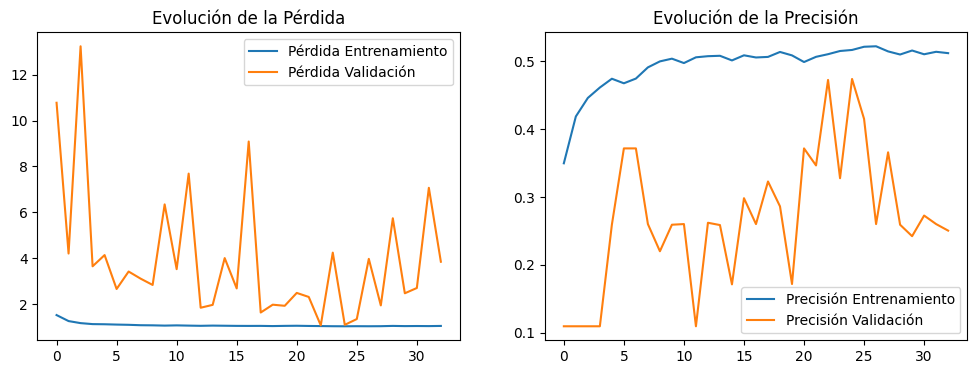

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


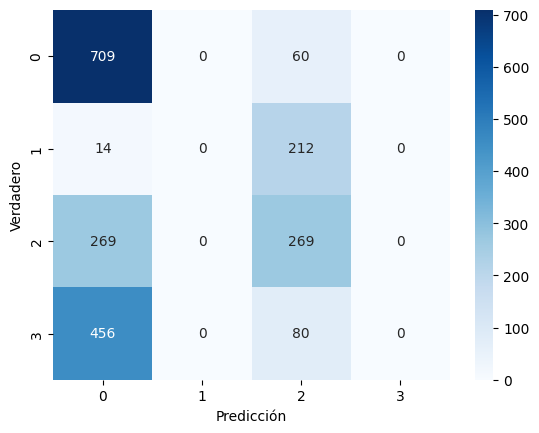

In [54]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Configurar memoria de GPU si está disponible
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("Memoria de GPU configurada correctamente.")
    except RuntimeError as e:
        print(e)

# Definir la arquitectura corregida
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Definir la entrada correctamente
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(y_train_encoded.shape[1], activation='softmax')  # Salida con softmax
])

# Compilar el modelo corregido
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Configurar Early Stopping para evitar sobreajuste
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo corregido
history = model.fit(X_train, y_train_encoded,
                    epochs=100, batch_size=32,
                    validation_data=(X_test, y_test_encoded),
                    callbacks=[early_stop], verbose=2)

# Graficar la pérdida y precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.legend()
plt.title("Evolución de la Pérdida")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión Validación')
plt.legend()
plt.title("Evolución de la Precisión")

plt.show()

# === 9. Graficar la matriz de confusión ===
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

2b con corrección

Epoch 1/100
265/265 - 4s - 16ms/step - accuracy: 0.2976 - loss: 1.7025 - val_accuracy: 0.4485 - val_loss: 1.2466
Epoch 2/100
265/265 - 1s - 3ms/step - accuracy: 0.3432 - loss: 1.5289 - val_accuracy: 0.4543 - val_loss: 1.1802
Epoch 3/100
265/265 - 1s - 5ms/step - accuracy: 0.3851 - loss: 1.4079 - val_accuracy: 0.4717 - val_loss: 1.1569
Epoch 4/100
265/265 - 1s - 3ms/step - accuracy: 0.3995 - loss: 1.3680 - val_accuracy: 0.4659 - val_loss: 1.1352
Epoch 5/100
265/265 - 1s - 5ms/step - accuracy: 0.4059 - loss: 1.3202 - val_accuracy: 0.4756 - val_loss: 1.1212
Epoch 6/100
265/265 - 1s - 5ms/step - accuracy: 0.4162 - loss: 1.2883 - val_accuracy: 0.4964 - val_loss: 1.1059
Epoch 7/100
265/265 - 1s - 5ms/step - accuracy: 0.4207 - loss: 1.2607 - val_accuracy: 0.4964 - val_loss: 1.0992
Epoch 8/100
265/265 - 1s - 3ms/step - accuracy: 0.4261 - loss: 1.2369 - val_accuracy: 0.4891 - val_loss: 1.0896
Epoch 9/100
265/265 - 1s - 3ms/step - accuracy: 0.4308 - loss: 1.2160 - val_accuracy: 0.4959 - val_loss

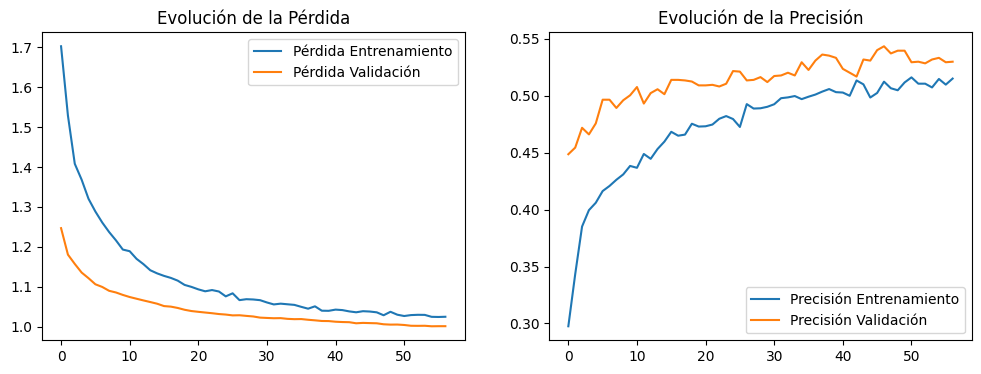

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


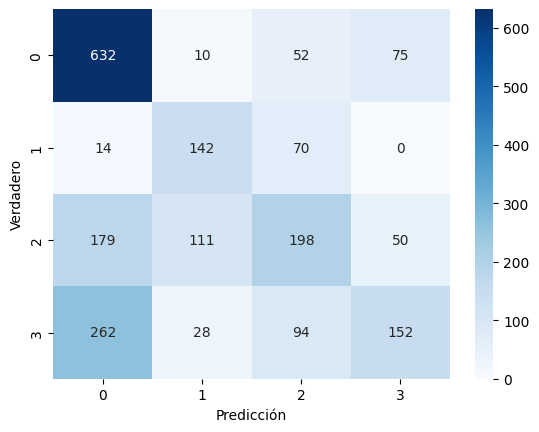

In [55]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 🚀 Normalización con StandardScaler para mejorar la estabilidad
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 🚀 Configuración del modelo mejorado
model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),

    layers.Dense(128, kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(64, kernel_initializer='he_normal'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(y_train_encoded.shape[1], activation='softmax')
])

# 🚀 Optimización con tasa de aprendizaje más baja
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 🚀 Early stopping basado en `val_accuracy`
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# 🚀 Entrenamiento
history = model.fit(X_train, y_train_encoded,
                    epochs=100, batch_size=32,
                    validation_data=(X_test, y_test_encoded),
                    callbacks=[early_stop], verbose=2)

# 🚀 Graficar resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.legend()
plt.title("Evolución de la Pérdida")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión Validación')
plt.legend()
plt.title("Evolución de la Precisión")

plt.show()

# === 9. Graficar la matriz de confusión ===
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

##2c

2c sin corrección

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


265/265 - 3s - 10ms/step - accuracy: 0.2533 - loss: 0.3726 - val_accuracy: 0.2600 - val_loss: 0.3700
Epoch 2/50
265/265 - 1s - 3ms/step - accuracy: 0.2477 - loss: 0.3762 - val_accuracy: 0.1092 - val_loss: 0.4454
Epoch 3/50
265/265 - 1s - 5ms/step - accuracy: 0.2523 - loss: 0.3739 - val_accuracy: 0.3717 - val_loss: 0.3142
Epoch 4/50
265/265 - 2s - 8ms/step - accuracy: 0.2523 - loss: 0.3739 - val_accuracy: 0.1092 - val_loss: 0.4454
Epoch 5/50
265/265 - 1s - 5ms/step - accuracy: 0.3315 - loss: 0.3340 - val_accuracy: 0.3717 - val_loss: 0.3142
Epoch 6/50
265/265 - 1s - 5ms/step - accuracy: 0.3572 - loss: 0.3214 - val_accuracy: 0.3717 - val_loss: 0.3142
Epoch 7/50
265/265 - 1s - 3ms/step - accuracy: 0.3572 - loss: 0.3214 - val_accuracy: 0.3717 - val_loss: 0.3142
Epoch 8/50
265/265 - 1s - 5ms/step - accuracy: 0.3572 - loss: 0.3214 - val_accuracy: 0.3717 - val_loss: 0.3142
Epoch 9/50
265/265 - 1s - 5ms/step - accuracy: 0.3572 - loss: 0.3214 - val_accuracy: 0.3717 - val_loss: 0.3142
Epoch 10/50

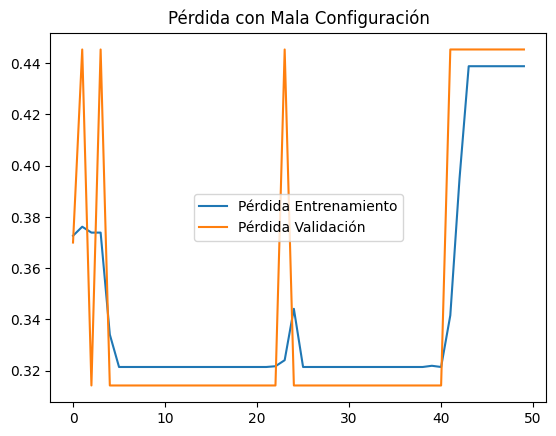

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


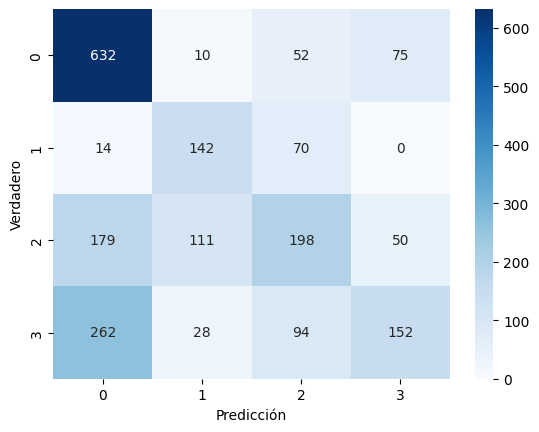

In [56]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# === 1. Red Neuronal con Mala Configuración ===
bad_model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(y_train_encoded.shape[1], activation='softmax')  # Salida con softmax
])

# === 2. Mala configuración del modelo ===
bad_model.compile(optimizer=keras.optimizers.Adam(learning_rate=1.0),  # Learning rate muy alto
                  loss='mse',  # MSE en lugar de categorical_crossentropy
                  metrics=['accuracy'])

# === 3. Entrenar la Red con Mala Configuración ===
bad_history = bad_model.fit(X_train, y_train_encoded,
                            epochs=50, batch_size=32,
                            validation_data=(X_test, y_test_encoded),
                            verbose=2)

# === 4. Graficar la pérdida para ver el mal desempeño ===
plt.plot(bad_history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(bad_history.history['val_loss'], label='Pérdida Validación')
plt.legend()
plt.title("Pérdida con Mala Configuración")
plt.show()

# === 9. Graficar la matriz de confusión ===
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

2c con corrección

Epoch 1/50
265/265 - 5s - 21ms/step - accuracy: 0.4455 - loss: 1.2757 - val_accuracy: 0.5109 - val_loss: 1.0991
Epoch 2/50
265/265 - 2s - 7ms/step - accuracy: 0.5093 - loss: 1.0759 - val_accuracy: 0.5486 - val_loss: 1.0130
Epoch 3/50
265/265 - 1s - 5ms/step - accuracy: 0.5272 - loss: 1.0136 - val_accuracy: 0.5732 - val_loss: 0.9646
Epoch 4/50
265/265 - 1s - 3ms/step - accuracy: 0.5446 - loss: 0.9825 - val_accuracy: 0.5452 - val_loss: 0.9565
Epoch 5/50
265/265 - 1s - 5ms/step - accuracy: 0.5540 - loss: 0.9519 - val_accuracy: 0.5747 - val_loss: 0.9574
Epoch 6/50
265/265 - 1s - 4ms/step - accuracy: 0.5612 - loss: 0.9408 - val_accuracy: 0.5636 - val_loss: 0.9140
Epoch 7/50
265/265 - 1s - 3ms/step - accuracy: 0.5647 - loss: 0.9272 - val_accuracy: 0.5921 - val_loss: 0.9122
Epoch 8/50
265/265 - 1s - 5ms/step - accuracy: 0.5800 - loss: 0.9061 - val_accuracy: 0.5935 - val_loss: 0.8929
Epoch 9/50
265/265 - 1s - 5ms/step - accuracy: 0.5811 - loss: 0.8870 - val_accuracy: 0.5781 - val_loss: 0.8781


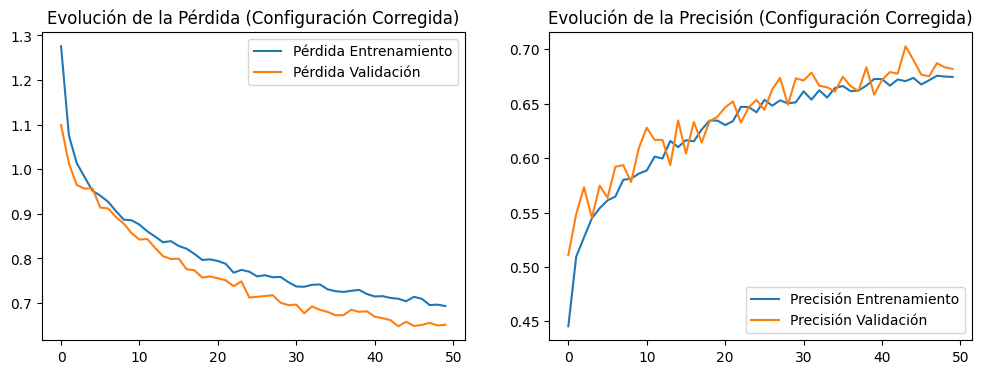

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


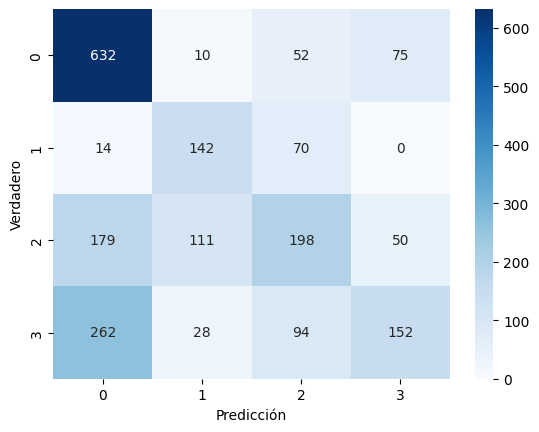

In [57]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 🚀 Modelo corregido
fixed_model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),  # Evitar sobreajuste

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(y_train_encoded.shape[1], activation='softmax')  # Función de activación correcta
])

# 🚀 Corrección total: categorical_crossentropy y learning rate óptimo
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

fixed_model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',  # CORRECCIÓN: función de pérdida correcta
                    metrics=['accuracy'])

# 🚀 Early Stopping más agresivo para evitar sobreajuste
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 🚀 Entrenamiento
fixed_history = fixed_model.fit(X_train, y_train_encoded,
                                epochs=50, batch_size=32,
                                validation_data=(X_test, y_test_encoded),
                                callbacks=[early_stop], verbose=2)

# 🚀 Graficar resultados
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fixed_history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(fixed_history.history['val_loss'], label='Pérdida Validación')
plt.legend()
plt.title("Evolución de la Pérdida (Configuración Corregida)")

plt.subplot(1, 2, 2)
plt.plot(fixed_history.history['accuracy'], label='Precisión Entrenamiento')
plt.plot(fixed_history.history['val_accuracy'], label='Precisión Validación')
plt.legend()
plt.title("Evolución de la Precisión (Configuración Corregida)")

plt.show()

# === 9. Graficar la matriz de confusión ===
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_encoded, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

##2d

ExactExplainer explainer: 2070it [01:15, 23.59it/s]


TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 1000x600 with 0 Axes>

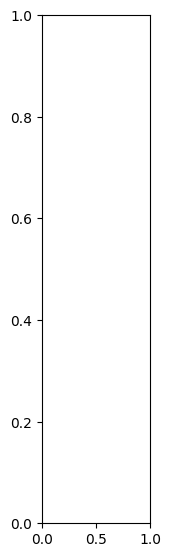

In [58]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import os

# Forzar uso de CPU en caso de errores con GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Crear el explainer SHAP basado en el modelo corregido del 2c
explainer = shap.Explainer(fixed_model, X_train)

# Calcular los valores SHAP para el conjunto de prueba
shap_values = explainer(X_test)

# Generar el gráfico de importancia de variables
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_test)

#3 bono

Modelo del punto 2b corregido

ExactExplainer explainer: 8480it [05:22, 25.45it/s]


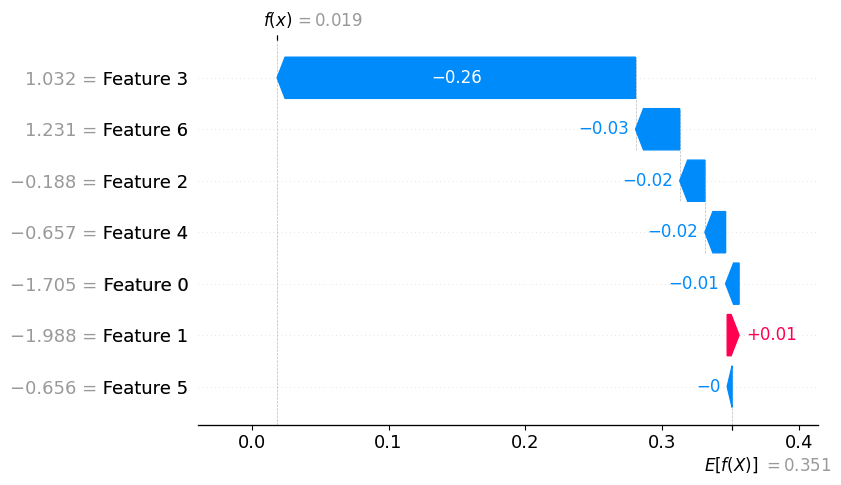

In [59]:
import shap

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)


shap.plots.waterfall(shap_values[0, :, 0])




Modelo del punto 2c corregido

ExactExplainer explainer: 8480it [05:03, 26.94it/s]                          


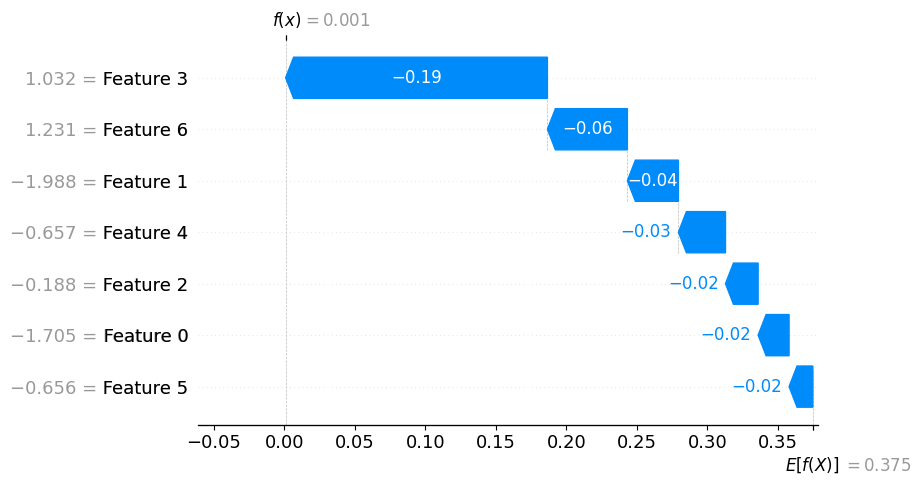

In [60]:
explainer = shap.Explainer(fixed_model, X_train)
shap_values = explainer(X_train)


shap.plots.waterfall(shap_values[0, :, 0])